In [2]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bcb import currency, sgs
import bizdays

import myfuncs as my

In [3]:
MARKET_CALENDAR = bizdays.Calendar.load('ANBIMA.cal')

In [38]:
ds_contrs = [my.get_contracts(dt) for dt in MARKET_CALENDAR.seq('2021-09-01', '2021-11-01')]

In [39]:
ds_contrs = pd.concat(ds_contrs, axis=0)

In [40]:
ds_contrs

,DataRef,Mercadoria,CDVencimento,PUAnterior,PUAtual,Variacao,Vencimento
0,2021-09-01,AFS,U21,14465.000,14465.000,0.000,2021-09-01
1,2021-09-01,AFS,V21,14578.900,14460.500,-118.400,2021-10-01
2,2021-09-01,AFS,X21,14631.200,14516.600,-114.600,2021-11-01
3,2021-09-01,AFS,Z21,14692.500,14575.200,-117.300,2021-12-01
4,2021-09-01,AFS,F22,14755.900,14636.900,-119.000,2022-01-01
...,...,...,...,...,...,...,...
565,2021-11-01,ZAR,Z21,3674.737,3676.744,2.007,2021-12-01
566,2021-11-01,ZAR,F22,3684.471,3687.018,2.547,2022-01-01
567,2021-11-01,ZAR,G22,3696.898,3698.199,1.301,2022-02-01
568,2021-11-01,ZAR,H22,3713.061,3713.278,0.217,2022-03-01


In [41]:
ds_contrs.to_parquet('contracts_202109_202111.parquet')

In [75]:
ds_DI1_contrs = ds_contrs[(ds_contrs['Mercadoria'] == 'DI1') &
                          (ds_contrs['CDVencimento'].isin(('V21', 'X21'))) & 
                          (ds_contrs['PUAtual'] != 100000)]

In [76]:
cal = bizdays.Calendar.load('ANBIMA.cal')
df = ds_DI1_contrs.copy()
df['Maturity'] = df['Vencimento'].map(cal.following)
df['DU'] = df.apply(lambda x: cal.bizdays(x['DataRef'], x['Maturity']), axis=1)
df['Rate'] = (100000 / df['PUAtual'])**(252 / df['DU']) - 1
df['DataRef'] = pd.to_datetime(df['DataRef'])

In [77]:
# df[df['DataRef'] <= '2021-09-22', 'NextMeeting']
df.loc[df['DataRef'] <= '2021-09-22', 'NextMeeting'] = pd.to_datetime('2021-09-22')
df.loc[df['DataRef'] > '2021-09-22', 'NextMeeting'] = pd.to_datetime('2021-10-27')
df.loc[df['DataRef'] >= '2021-10-27', 'NextMeeting'] = pd.to_datetime('2021-12-08')

In [87]:
df['DU_NextMeeting'] = list(cal.vec.bizdays(df['DataRef'], df['NextMeeting']))

In [79]:
df.head()

,DataRef,Mercadoria,CDVencimento,PUAnterior,PUAtual,Variacao,Vencimento,Maturity,DU,Rate,NextMeeting,DU_NextMeeting
196,2021-09-01,DI1,V21,99558.77,99558.60,-0.17,2021-10-01,2021-10-01,21,0.05452,2021-09-22,14
197,2021-09-01,DI1,X21,99076.35,99073.19,-3.16,2021-11-01,2021-11-01,41,0.05890,2021-09-22,14
181,2021-09-02,DI1,V21,99578.43,99577.77,-0.66,2021-10-01,2021-10-01,20,0.05476,2021-09-22,13
182,2021-09-02,DI1,X21,99092.93,99094.21,1.28,2021-11-01,2021-11-01,40,0.05900,2021-09-22,13
181,2021-09-03,DI1,V21,99597.61,99597.13,-0.48,2021-10-01,2021-10-01,19,0.05500,2021-09-22,12


In [54]:
cdi = sgs.get(dict(CDI=4389), start_date='2021-09-01', end_date='2021-11-01')

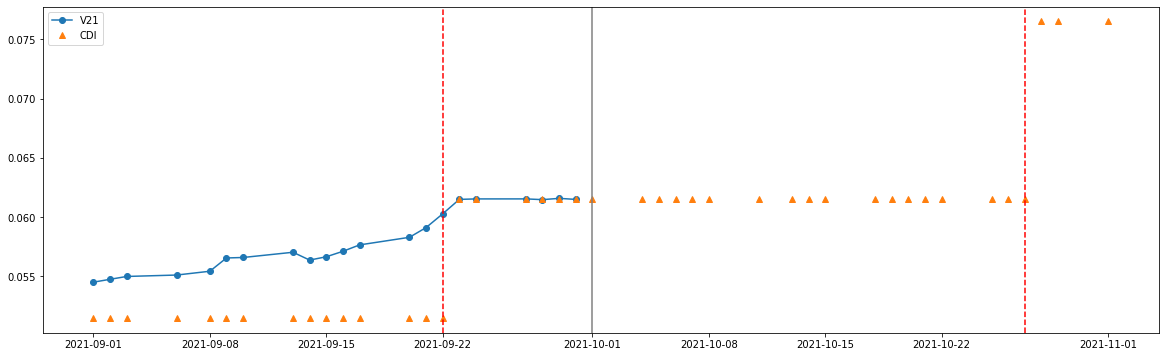

In [82]:
plt.figure(figsize=(20, 6))
_df = df[df['CDVencimento'] == 'V21']
plt.plot(_df['DataRef'], _df['Rate'], '-o')
plt.plot(cdi.index, cdi['CDI']/100, '^')
plt.legend(['V21', 'CDI'])
plt.axvline(x=pd.to_datetime('2021-10-01'), ls='-', color='grey')
plt.axvline(x=pd.to_datetime('2021-09-22'), ls='--', color='red')
plt.axvline(x=pd.to_datetime('2021-10-27'), ls='--', color='red')
plt.show()

In [84]:
df_v21 = df[df['CDVencimento'] == 'V21']

In [90]:
df_v21 = pd.merge(df_v21, cdi.reset_index(), left_on='DataRef', right_on='date')

In [96]:
f1 = (1 + df_v21['Rate']) ** (df_v21['DU']/252)
f2 = (1 + df_v21['CDI']/100) ** (df_v21['DU_NextMeeting']/252)
10000*((f1 / f2) ** (252 / (df_v21['DU'] - df_v21['DU_NextMeeting'])) - 1 - df_v21['CDI']/100)

0      90.846410
1      93.422138
2      95.283944
3      93.326139
4      95.945942
5     116.001960
6     109.592093
7     111.105549
8      90.824270
9      88.616962
10     88.454010
11     88.114998
12     87.523558
13     87.138726
14     87.801433
15      0.002314
16     -0.112532
17     -0.094398
18      0.040874
19     -0.100366
20      0.001458
dtype: float64